# Traffic Sign Classifier using JAX and FLAX
Hi,
In this project we will be creating a classification model for traffic signs using JAX and FLAX.

JAX is a framework which is used for high-performance computing and machine learning research developed at Google Research. It has a NumPy-consitent API and focuses on differentiating, vectorizing, parallelizing, and compiling GPU/TPU Just-In-Time. JAX is hardware agnostic and meant for speed.

FLAX is a JAX-based neural network library that was initially developed by Google Research's Brain Team. It allows us to more easily design and train neural networks. FLAX does not have any dataloaders so for that we will be using PyTorch.

In [1]:
import jax
import os
import pandas as pd
import re
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision import transforms
from typing import Any
import jax.nn
import jax.numpy as jnp
import jax.random
import train
import math

/root/miniconda3/envs/jax/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda3/envs/jax/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /root/miniconda3/envs/jax/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Check that JAX has found the GPU
# Should display something like [StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]
jax.local_devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [3]:
# Create dataframe containing the image paths and classes
res = []
for root, dirs, files in os.walk('./traffic_Data/DATA/', topdown=True):
    if (len(files) > 0):
        for name in files:
            res.append(root + '/' + name)

sec = []
for name in res:
    m = re.search(r"(\d+)", name)
    sec.append(int(m.group()))

data_tuples = list(zip(sec, res))
df = pd.DataFrame(data_tuples, columns = ['Class', "Path"])

In [4]:
# Define a PyTorch dataset for our data
class TrafficDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_label = row['Class']
        img = Image.open(row['Path'])
        if self.transform:
            img = self.transform(img)
        return img, img_label

In [5]:
# CNN-models need all images of the same dimensions. 
# This script will look at all the images and find the smallest width and height.
minheight = 160
minwidth = 146
for root, dirs, files in os.walk('./traffic_Data/DATA/', topdown=True):
    if (len(files) > 0):
        for name in files:
            img = cv2.imread(root + '/' + name)
            if (img.shape[0] < minheight) :
                minheight = img.shape[0]
            if (img.shape[1] < minwidth):
                minwidth = img.shape[1]
print(f"({minheight}, {minwidth})")

(28, 26)


In [6]:
# Defining the transformations for the datasets.
# RandomAffine and RandomHorizontalFlip are data augmentation techniques to provide us with more data.
# We resize the data to the smallest height and width that we found in the previous cell.
# We do a 80/20 split of the data so that we have a training dataset and a validation dataset.
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 26

training_transform = transforms.Compose([
    transforms.RandomAffine(degrees = (-30, 30),
                            translate = (0.0, 0.2)),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((IMAGE_HEIGHT,
                       IMAGE_WIDTH)),
    np.array
])

testing_transform = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT,
                       IMAGE_WIDTH)),
    np.array])

np.random.seed(37)
msk = np.random.rand(len(df)) < 0.8

train_df = df[msk].reset_index()
val_df = df[~msk].reset_index()

train_ds = TrafficDataset(train_df, transform = training_transform)
val_ds = TrafficDataset(val_df, transform = testing_transform)
len(train_ds), len(val_ds)

(3330, 838)

In [7]:
# Now we create our dataloaders.
# JAX does not work with the PyTorch tensors so we create the custome_collate_fn to convert data to NumPy format.
BATCH_SIZE = 128
def custom_collate_fn(batch):
    transponded_data = list(zip(*batch))

    labels = np.array(transponded_data[1])
    imgs = np.stack(transponded_data[0])
    
    return imgs, labels

train_dataloader = DataLoader(train_ds,
                              batch_size = BATCH_SIZE,
                              shuffle = True, drop_last = True,
                              num_workers = 0,
                              collate_fn=custom_collate_fn)
test_dataloader = DataLoader(val_ds,
                             batch_size = BATCH_SIZE,
                             shuffle = True, drop_last = True,
                             num_workers = 0,
                             collate_fn=custom_collate_fn)


In [8]:
# Lets load one batch with the training dataloader to see that everything works.
(image_batch, label_batch) = next(iter(train_dataloader))
print(image_batch.shape)
print(label_batch.shape)

(128, 28, 26, 3)
(128,)


In [9]:
# Lets load one batch with the test dataloader to see that everything works.
(val_image_batch, val_label_batch) = next(iter(test_dataloader))
print(val_image_batch.shape)
print(val_label_batch.shape)

(128, 28, 26, 3)
(128,)


In [10]:
# Training
# We call upon the train_epoch function for as many epochs that we want, updating the state each time.
SEED = 0
LEARNING_RATE = 0.1
MOMENTUM = 0.9
NUM_EPOCHS = 50

train_state = train.create_train_state(jax.random.PRNGKey(SEED), LEARNING_RATE, MOMENTUM)
train_acc = []
test_acc = []
for epoch in range(1, NUM_EPOCHS + 1):
    train_state, batch_stats = train.train_epoch(train_state, train_dataloader)
    print(f"Train epoch {epoch}, accuracy {np.round(batch_stats['accuracy'] * 100, 3)}")
    train_acc.append(batch_stats['accuracy'])

    test_accuracy = train.evaluate_model(train_state, test_dataloader)
    print(f"Test epoch {epoch}, accuracy: {np.round(test_accuracy * 100, 3)}")
    test_acc.append(test_accuracy)
    

100%|██████████| 26/26 [00:11<00:00,  2.23it/s]


Train epoch 1, accuracy 12.139
Test epoch 1, accuracy: 2.214


100%|██████████| 26/26 [00:04<00:00,  5.57it/s]


Train epoch 2, accuracy 20.583
Test epoch 2, accuracy: 8.464


100%|██████████| 26/26 [00:04<00:00,  5.58it/s]


Train epoch 3, accuracy 34.075
Test epoch 3, accuracy: 13.411


100%|██████████| 26/26 [00:05<00:00,  5.16it/s]


Train epoch 4, accuracy 41.887
Test epoch 4, accuracy: 27.995


100%|██████████| 26/26 [00:05<00:00,  4.77it/s]


Train epoch 5, accuracy 45.042
Test epoch 5, accuracy: 18.229


100%|██████████| 26/26 [00:04<00:00,  5.52it/s]


Train epoch 6, accuracy 51.593
Test epoch 6, accuracy: 48.958


100%|██████████| 26/26 [00:04<00:00,  5.45it/s]


Train epoch 7, accuracy 60.246
Test epoch 7, accuracy: 32.161


100%|██████████| 26/26 [00:04<00:00,  5.23it/s]


Train epoch 8, accuracy 59.826
Test epoch 8, accuracy: 58.333


100%|██████████| 26/26 [00:05<00:00,  5.18it/s]


Train epoch 9, accuracy 67.758
Test epoch 9, accuracy: 70.833


100%|██████████| 26/26 [00:05<00:00,  4.80it/s]


Train epoch 10, accuracy 72.656
Test epoch 10, accuracy: 69.661


100%|██████████| 26/26 [00:06<00:00,  3.94it/s]


Train epoch 11, accuracy 76.472
Test epoch 11, accuracy: 77.214


100%|██████████| 26/26 [00:05<00:00,  4.71it/s]


Train epoch 12, accuracy 78.456
Test epoch 12, accuracy: 67.708


100%|██████████| 26/26 [00:04<00:00,  5.60it/s]


Train epoch 13, accuracy 79.447
Test epoch 13, accuracy: 81.38


100%|██████████| 26/26 [00:04<00:00,  5.58it/s]


Train epoch 14, accuracy 83.113
Test epoch 14, accuracy: 77.214


100%|██████████| 26/26 [00:04<00:00,  5.56it/s]


Train epoch 15, accuracy 83.684
Test epoch 15, accuracy: 78.255


100%|██████████| 26/26 [00:06<00:00,  4.17it/s]


Train epoch 16, accuracy 83.984
Test epoch 16, accuracy: 83.464


100%|██████████| 26/26 [00:04<00:00,  5.54it/s]


Train epoch 17, accuracy 87.62
Test epoch 17, accuracy: 88.932


100%|██████████| 26/26 [00:05<00:00,  5.06it/s]


Train epoch 18, accuracy 89.243
Test epoch 18, accuracy: 84.375


100%|██████████| 26/26 [00:05<00:00,  5.07it/s]


Train epoch 19, accuracy 89.483
Test epoch 19, accuracy: 83.333


100%|██████████| 26/26 [00:04<00:00,  5.50it/s]


Train epoch 20, accuracy 91.587
Test epoch 20, accuracy: 88.542


100%|██████████| 26/26 [00:04<00:00,  5.47it/s]


Train epoch 21, accuracy 91.316
Test epoch 21, accuracy: 88.672


100%|██████████| 26/26 [00:05<00:00,  5.09it/s]


Train epoch 22, accuracy 92.458
Test epoch 22, accuracy: 89.974


100%|██████████| 26/26 [00:04<00:00,  5.29it/s]


Train epoch 23, accuracy 90.445
Test epoch 23, accuracy: 88.021


100%|██████████| 26/26 [00:04<00:00,  5.56it/s]


Train epoch 24, accuracy 93.78
Test epoch 24, accuracy: 93.75


100%|██████████| 26/26 [00:04<00:00,  5.55it/s]


Train epoch 25, accuracy 94.772
Test epoch 25, accuracy: 91.927


100%|██████████| 26/26 [00:05<00:00,  5.02it/s]


Train epoch 26, accuracy 93.63
Test epoch 26, accuracy: 94.401


100%|██████████| 26/26 [00:05<00:00,  5.10it/s]


Train epoch 27, accuracy 95.974
Test epoch 27, accuracy: 92.839


100%|██████████| 26/26 [00:05<00:00,  4.64it/s]


Train epoch 28, accuracy 94.952
Test epoch 28, accuracy: 92.318


100%|██████████| 26/26 [00:05<00:00,  4.37it/s]


Train epoch 29, accuracy 94.261
Test epoch 29, accuracy: 91.536


100%|██████████| 26/26 [00:04<00:00,  5.40it/s]


Train epoch 30, accuracy 95.793
Test epoch 30, accuracy: 94.271


100%|██████████| 26/26 [00:04<00:00,  5.39it/s]


Train epoch 31, accuracy 95.763
Test epoch 31, accuracy: 79.948


100%|██████████| 26/26 [00:04<00:00,  5.62it/s]


Train epoch 32, accuracy 94.381
Test epoch 32, accuracy: 94.271


100%|██████████| 26/26 [00:05<00:00,  4.80it/s]


Train epoch 33, accuracy 96.274
Test epoch 33, accuracy: 93.229


100%|██████████| 26/26 [00:07<00:00,  3.62it/s]


Train epoch 34, accuracy 97.206
Test epoch 34, accuracy: 95.573


100%|██████████| 26/26 [00:05<00:00,  4.98it/s]


Train epoch 35, accuracy 97.025
Test epoch 35, accuracy: 94.01


100%|██████████| 26/26 [00:05<00:00,  5.05it/s]


Train epoch 36, accuracy 97.175
Test epoch 36, accuracy: 96.224


100%|██████████| 26/26 [00:06<00:00,  4.28it/s]


Train epoch 37, accuracy 97.356
Test epoch 37, accuracy: 94.922


100%|██████████| 26/26 [00:06<00:00,  4.15it/s]


Train epoch 38, accuracy 97.536
Test epoch 38, accuracy: 96.094


100%|██████████| 26/26 [00:05<00:00,  5.18it/s]


Train epoch 39, accuracy 97.356
Test epoch 39, accuracy: 96.615


100%|██████████| 26/26 [00:05<00:00,  4.95it/s]


Train epoch 40, accuracy 97.296
Test epoch 40, accuracy: 95.573


100%|██████████| 26/26 [00:04<00:00,  5.66it/s]


Train epoch 41, accuracy 98.167
Test epoch 41, accuracy: 95.052


100%|██████████| 26/26 [00:04<00:00,  5.41it/s]


Train epoch 42, accuracy 97.957
Test epoch 42, accuracy: 94.141


100%|██████████| 26/26 [00:05<00:00,  5.16it/s]


Train epoch 43, accuracy 98.588
Test epoch 43, accuracy: 94.661


100%|██████████| 26/26 [00:05<00:00,  5.06it/s]


Train epoch 44, accuracy 98.107
Test epoch 44, accuracy: 96.354


100%|██████████| 26/26 [00:04<00:00,  5.43it/s]


Train epoch 45, accuracy 98.528
Test epoch 45, accuracy: 96.094


100%|██████████| 26/26 [00:05<00:00,  5.18it/s]


Train epoch 46, accuracy 98.377
Test epoch 46, accuracy: 95.703


100%|██████████| 26/26 [00:04<00:00,  5.48it/s]


Train epoch 47, accuracy 98.197
Test epoch 47, accuracy: 97.005


100%|██████████| 26/26 [00:04<00:00,  5.43it/s]


Train epoch 48, accuracy 98.768
Test epoch 48, accuracy: 97.135


100%|██████████| 26/26 [00:04<00:00,  5.23it/s]


Train epoch 49, accuracy 98.828
Test epoch 49, accuracy: 97.656


100%|██████████| 26/26 [00:04<00:00,  5.50it/s]


Train epoch 50, accuracy 98.888
Test epoch 50, accuracy: 96.745


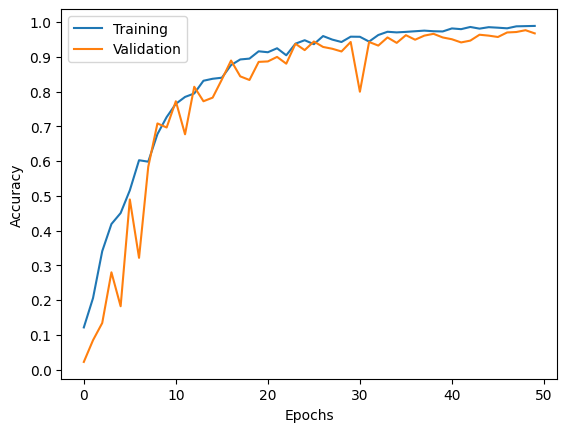

In [11]:
# Plotting Training History
# Here we plot the training and validation accuracy with each epoch.
# With 50 epochs we should see an accuracy of about 98% for both validation and training data.
import matplotlib.pyplot as plt
plt.plot(range(NUM_EPOCHS), train_acc, label='Training')
plt.plot(range(NUM_EPOCHS), test_acc, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.legend()
plt.show()

In [12]:
# Function that plots images with their predicted class
def show_img_pred(train_state, img_batch, label_names, num_imgs = 1):
    preds = train.CNN().apply({'params':train_state.params, 'batch_stats': train_state.batch_stats}, val_image_batch, training=False)
    preds = jnp.argmax(preds, -1)
    cols = 3
    rows = math.ceil(num_imgs / cols)
    fig = plt.figure(figsize=(10, 7))
    for i in range(num_imgs):
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img_batch[i], interpolation='nearest')
        plt.axis('off')
        plt.title(label_names[preds[i]])

In [13]:
# Import the names of the classes so that we can plot images with names rather than numbers
label_names = pd.read_csv('traffic_Data/labels.csv')
label_names = np.array(label_names['Name'])

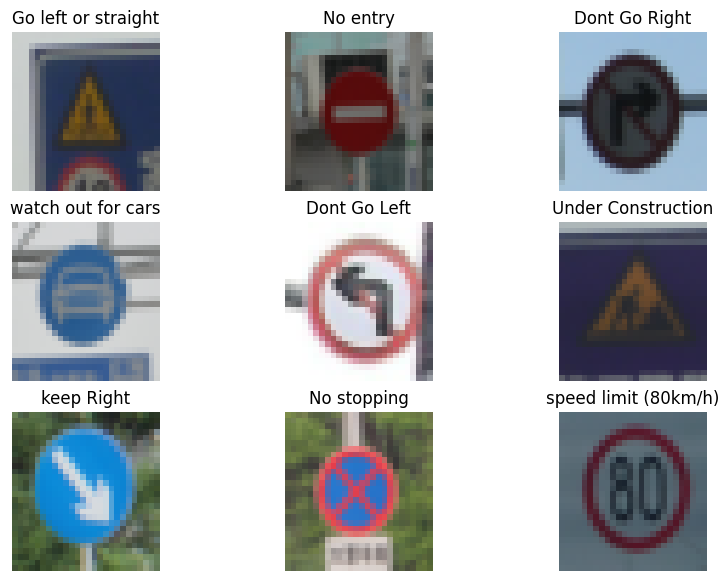

In [14]:
# Plotted images and their predictions.
# With a ~98% validation accuracy, almost all of the images should be correct.
show_img_pred(train_state, val_image_batch, label_names, num_imgs=9)